# Cleaning data: removing blur

$NO_2$ data is in principle very useful for estimating traffic. However, $NO_2$ is subject to weather. Wind will carry $NO_2$ over large distances, and rain will wash it out of the atmosphere. To be able to estimate traffic using $NO_2$ data, we will need to account for these distortions. 

In [54]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
import scipy.ndimage as scn
import scipy.signal as scs
import scipy.fftpack as scf
import scipy.stats as st
import skimage.restoration as sir
import skimage.segmentation as sis
import netCDF4 as nc

Looking at the data, it is hard to make out any single pointsources of $NO_2$. Weather has blurred our measurements. 

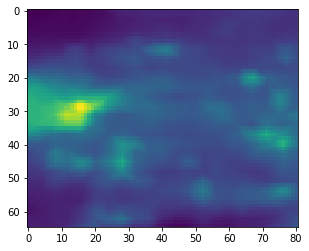

In [68]:
dataMarch1918 = nc.Dataset("./data/no2_germany_march2019_1800.nc", "r")
dataMarch1900 = nc.Dataset("./data/no2_germany_march2019_0000.nc", "r")
dataApril1918 = nc.Dataset("./data/no2_germany_april2019_1800.nc", "r")
dataApril1900 = nc.Dataset("./data/no2_germany_april2019_0000.nc", "r")
dataFebr1800 = nc.Dataset("./data/no2_germany_february2020_1800.nc", "r")
dataFebr0000 = nc.Dataset("./data/no2_germany_february2020_0000.nc", "r")
dataMarch1800 = nc.Dataset("./data/no2_germany_march2020_1800.nc", "r")
dataMarch0000 = nc.Dataset("./data/no2_germany_march2020_0000.nc", "r")
dataApril1800 = nc.Dataset("./data/no2_germany_april2020_1800.nc", "r")
dataApril0000 = nc.Dataset("./data/no2_germany_april2020_0000.nc", "r")

Tfeb, X, Y = dataFebr1800['tcno2'].shape
Tmarch, _, _ = dataMarch1800['tcno2'].shape
Tapril, _, _ = dataApril1800['tcno2'].shape
Tmeassure = 21
Tdelta = 30

beforeVals1800 = np.concatenate((dataMarch1918['tcno2'][Tmeassure:], dataApril1918['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
beforeVals0000 = np.concatenate((dataMarch1900['tcno2'][Tmeassure:], dataApril1900['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
afterVals1800 = np.concatenate((dataMarch1800['tcno2'][Tmeassure:], dataApril1800['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
afterVals0000 = np.concatenate((dataMarch0000['tcno2'][Tmeassure:], dataApril0000['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))

beforeVals1800mean = np.mean(beforeVals1800, axis=0)
beforeVals0000mean = np.mean(beforeVals0000, axis=0)
afterVals1800mean = np.mean(afterVals1800, axis=0)
afterVals0000mean = np.mean(afterVals0000, axis=0)


plt.imshow(afterVals1800mean)

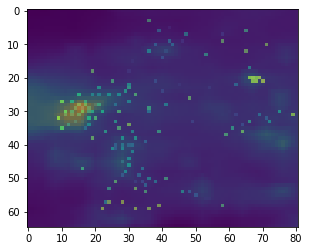

In [65]:
def round(v):
    return int(v + 0.5)


def coordsToIndex(lon, lat):
    R, C = beforeVals0000mean.shape
    lat0 = 47
    lat1 = 55
    lon0 = 5
    lon1 = 15
    deltaLat = (lat1 - lat0) / R
    deltaLon = (lon1 - lon0) / C
    # lat = lat0 + (R-r) * deltaLat
    r = R - ((lat - lat0) / deltaLat)
    # col = col0 + c * deltaLon
    c = (lon - lon0) / deltaLon
    return round(r), round(c)


lksAll = gpd.read_file('./data/landkreise_risklayer.geojson')
lks = lksAll[lksAll['type'] != 'bundesland']
cityPop = 200000
cities = lks[lks['population'] >= cityPop]


markers = np.zeros(beforeVals0000mean.shape)

geometries = cities.geometry
for i, g in enumerate(geometries):
    center = g.centroid
    lon, lat = center.coords[0]
    r, c = coordsToIndex(lon, lat)
    markers[r, c] = i


plt.imshow(afterVals1800mean)
plt.imshow(markers, alpha=0.5)

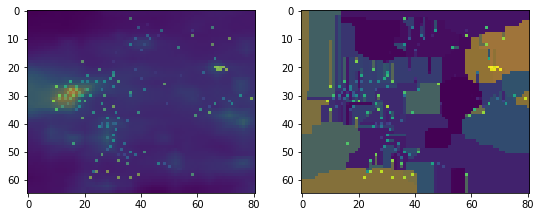

In [66]:
markersNew = sis.watershed(-afterVals1800mean, markers)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
axes[0].imshow(afterVals1800mean)
axes[0].imshow(markers, alpha=0.5)
axes[1].imshow(markersNew)
axes[1].imshow(markers, alpha=0.5)